## Import Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns


import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline

## Load and Preprocess SETI Data

In [36]:
train_img=pd.read_csv('dataset/Train/images.csv',header=None)

In [37]:
train_lab=pd.read_csv('dataset/Train/labels.csv',header=None)

In [38]:
val_img=pd.read_csv('dataset/Validation/images.csv',header=None)

In [39]:
val_lab=pd.read_csv('dataset/Validation/labels.csv',header=None)

In [40]:
print('Train Set Data: ',train_img.shape, train_lab.shape)
print('Validation Set Data: ',val_img.shape, val_lab.shape )

Train Set Data:  (3200, 8192) (3200, 4)
Validation Set Data:  (800, 8192) (800, 4)


In [41]:
x_train=train_img.values.reshape(3200,64,128,1)
x_val=val_img.values.reshape(800,64,128,1)

##  Visualisation

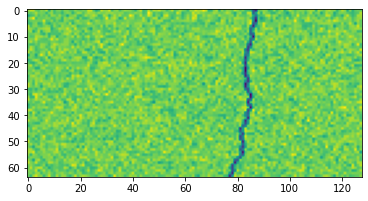

In [42]:
img=np.squeeze(x_train[1])
plt.imshow(img)

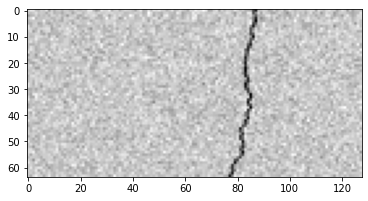

In [43]:
img=np.squeeze(x_train[1])
plt.imshow(img,cmap='gray')

##  Create Training and Validation Data Generators

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_train=ImageDataGenerator(horizontal_flip=True)
data_train.fit(x_train)
data_val=ImageDataGenerator(horizontal_flip=True)
data_val.fit(x_val)

##  Creating the CNN Model

In [45]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
# Initialising the CNN
model=Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4,activation='softmax') )

##  Learning Rate Scheduling and Compile the Model

In [47]:
initial_learning_rate=0.005
import tensorflow as tf
decay_lr=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
    )
optimizer=Adam(decay_lr)

In [48]:
model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 64, 32)        25632     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 64, 32)       

## Training the Model

In [50]:
checkpoint=ModelCheckpoint('model.h5',monitor='val_loss',save_weights_only=True,mode='min',verbose=0)
callback=[PlotLossesCallback(),checkpoint]
batch_size=32


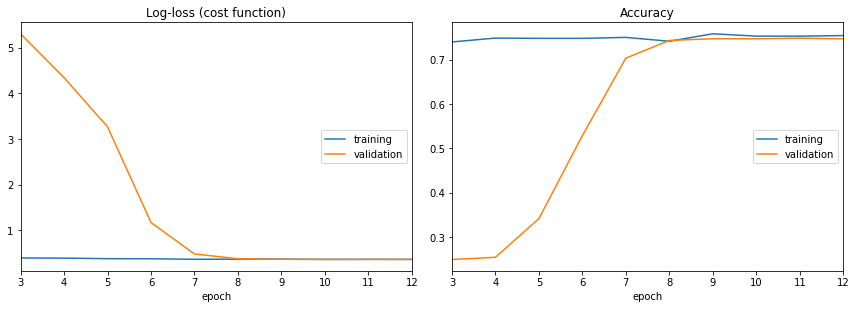

Log-loss (cost function):
training   (min:    0.367, max:    0.632, cur:    0.368)
validation (min:    0.364, max:    5.383, cur:    0.365)

Accuracy:
training   (min:    0.681, max:    0.759, cur:    0.755)
validation (min:    0.249, max:    0.749, cur:    0.748)
100/100 [==============================] - 78s 782ms/step - loss: 0.3678 - acc: 0.7547 - val_loss: 0.3649 - val_acc: 0.7475


In [51]:
history=model.fit(data_train.flow(x_train,train_lab,batch_size=batch_size,shuffle=True),
        steps_per_epoch=len(x_train)//batch_size,
        validation_data=data_val.flow(x_val,val_lab,batch_size=batch_size,shuffle=True),
        validation_steps=len(x_val)//batch_size,
        callbacks=callback,
                  epochs=12
)

##  Model Evaluation

In [54]:
model.evaluate(x_val,val_lab)

800/800 [==============================] - 2s 3ms/sample - loss: 0.3645 - acc: 0.7462


[0.3645054230000824, 0.74625]

In [69]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
y_true=[]
for i in range(len(val_lab)):
    y_true.append(np.argmax(val_lab.iloc[i]))
y_true=np.array(y_true)

In [70]:
y_pred=np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.50      0.98      0.66       200
           2       0.44      0.02      0.04       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.74      0.75      0.67       800
weighted avg       0.74      0.75      0.67       800

